<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch03_CH01_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오픈 도메인 대화시스템 실습
## 생성기반 방식 TEXT -> Encoder -> Decoder -> TEXT (End2End)
- Transformer사용
    - RNN사용 X
    - FNN, Self-Attention
- Dataset : https://github.com/songys/Chatbot_data



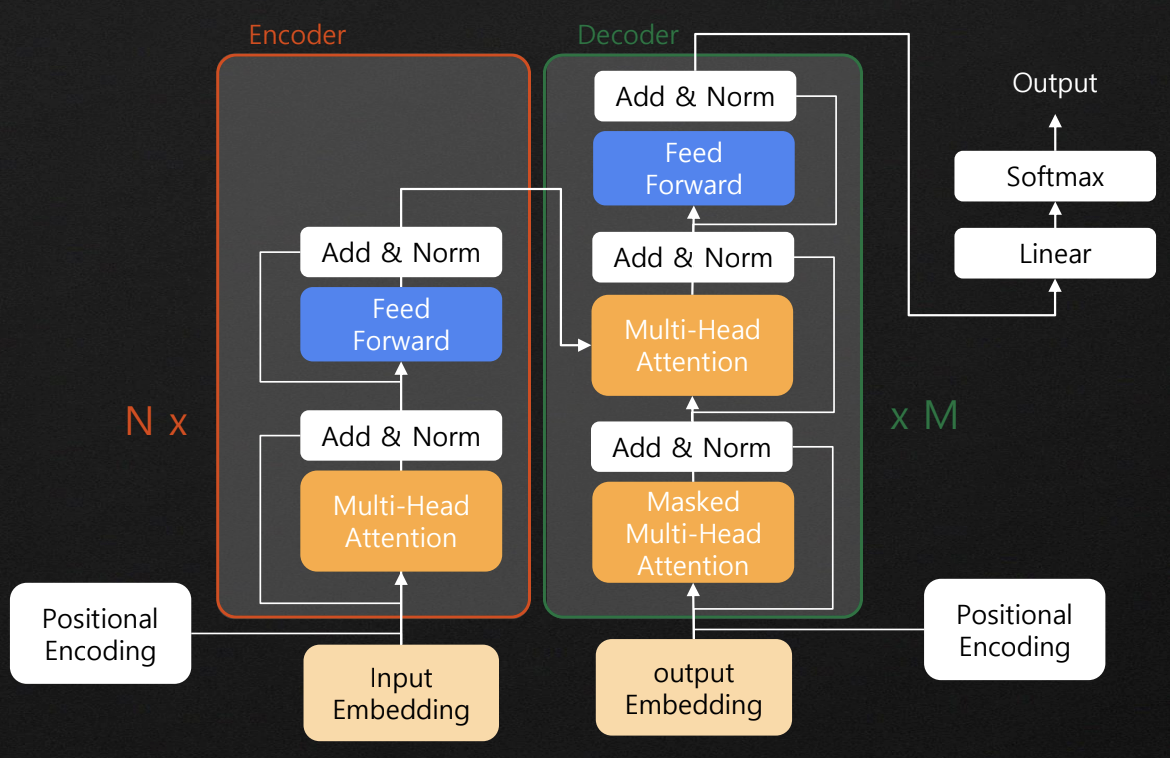

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentencepiece
!pip install pytorch-crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.7 MB/s eta 0:00:00


In [35]:
import os
import sys
import json
import torch
import random
import torch.utils.data as data
import numpy as np
import pandas as pd
import sentencepiece as spm
import re


from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from tqdm import tqdm
from tqdm import trange
import torch.nn.functional as F
#from torch.utils.tensorboard import SummaryWriter

%cd /content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇
from src.model import save
%cd /root

/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇
/root


In [10]:
train_data = pd.read_csv('/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/ChatbotData.csv')
train_data.head()
# label 사용 x

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## sentence piece 로 vocab생성
- SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing
- Taku Kudo, John Richardson, Google
- RNN은 기본적으로 vocab의 크기가 계산량에 영향을 주고 있습니다.
그래서 적당한 크기의 vocab을 사용하게 됩니다. 문제는 여기서 많이 발생합니다.
우리는 vocab을 만들때 미등록 단어가 발생하게 되고 실제로 입력으로 들어왔을때 UNK토큰으로 대체하게 됩니다.
이 과정에서 정보의 손실이 발생하고 성능의 문제를 일으킬수 있습니다.
그런 점을 보완하고자 sentencepiece를 tokenizer로 사용하려고 합니다.
sentencepiece의 기본 아이디어는 단어(word)의 부분단어(subword)로 모든 단어를 표현하고자 하는게 아이디어입니다.
이때 사용하는게 단어들의 빈도수를 사용하여 subword로 나눌지 말지를 판단하게 됩니다.

In [12]:
corpus = "/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/chit-chat_corpus.txt"
prefix = "chatbot"
vocab_size = 16000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

## Load & Test

In [13]:
vocab_file = "/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/chatbot.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)
line = "3박4일 정도 놀러가고 싶다"
pieces = vocab.encode_as_pieces(line)
ids = vocab.encode_as_ids(line)


print(line)
print(pieces)
print(ids)

3박4일 정도 놀러가고 싶다
['▁3', '박', '4', '일', '▁정도', '▁놀러가고', '▁싶다']
[473, 15432, 15399, 14972, 982, 3503, 201]


In [14]:
class Preprocessing:
    '''
    데이터의 최대 token길이가 10이지만
    실제 환경에서는 얼마의 길이가 들어올지 몰라 적당한 길이 부여
    '''

    def __init__(self, max_len = 20):
        self.max_len = max_len
        self.PAD = 0

    def pad_idx_sequencing(self, q_vec):
        q_len = len(q_vec)
        diff_len = q_len - self.max_len
        if(diff_len>0):
            q_vec = q_vec[:self.max_len]
            q_len = self.max_len
        else:
            pad_vac = [0] * abs(diff_len)
            q_vec += pad_vac

        return q_vec

    def make_batch(self):
        pass

In [15]:
class ChitChatDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor, labels):
        super(ChitChatDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor
        self.labels = labels

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.labels[index]

    def __len__(self):
        return len(self.x)



In [22]:
class MakeDataset:
    def __init__(self):

        self.chitchat_data_dir = "/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/ChatbotData.csv"

        self.prep = Preprocessing()
        vocab_file = "/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/chatbot.model"
        self.transformers_tokenizer = spm.SentencePieceProcessor()
        self.transformers_tokenizer.load(vocab_file)

    def encode_dataset(self, dataset):
        token_dataset = []
        for data in dataset:
            token_dataset.append( [2] + self.transformers_tokenizer.encode_as_ids(data) + [3]) # begin of sequence (2), end of sequence (3)
        return token_dataset

    def make_chitchat_dataset(self, train_ratio = 0.8):
        chitchat_dataset = pd.read_csv(self.chitchat_data_dir)
        Qs = chitchat_dataset["Q"].tolist()
        As = chitchat_dataset["A"].tolist()
        label = chitchat_dataset["label"].tolist()

        Qs = self.encode_dataset(Qs)
        As = self.encode_dataset(As)

        self.prep.max_len = 40
        x, y = [], []
        for q, a in zip(Qs,As):
            x.append(self.prep.pad_idx_sequencing(q))
            y.append(self.prep.pad_idx_sequencing(a))
        x = torch.tensor(x)
        y = torch.tensor(y)
        x_len = x.size()[0]
        train_size = int(x_len*train_ratio)

        if(train_ratio == 1.0):
            train_x = x[:train_size]
            train_y = y[:train_size]
            train_label = label[:train_size]
            train_dataset = ChitChatDataset(train_x,train_y,train_label)
            return train_dataset, None
        else:
            train_x = x[:train_size]
            train_y = y[:train_size]
            train_label = label[:train_size]

            test_x = x[train_size+1:]
            test_y = y[train_size+1:]
            test_label = label[train_size+1:]

            train_dataset = ChitChatDataset(train_x,train_y,train_label)
            test_dataset = ChitChatDataset(test_x,test_y,test_label)

            return train_dataset, test_dataset

In [23]:
dataset = MakeDataset()

train_dataset, test_dataset = dataset.make_chitchat_dataset(1.0)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

## Attention Is All You Need
- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
-tensorflow transformer chatbot code : https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html

In [24]:
from torch.nn import Transformer
from torch import nn
import torch
import math
from tqdm import tqdm

In [25]:
class Tformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, dff, num_layers, dropout_p=0.5):
        super(Tformer, self).__init__()
        self.transformer = Transformer(dim_model, num_heads, dim_feedforward=dff, num_encoder_layers=num_layers, num_decoder_layers=num_layers,dropout=dropout_p)
        self.pos_encoder = PositionalEncoding(dim_model, dropout_p)
        self.encoder = nn.Embedding(num_tokens, dim_model)

        self.pos_encoder_d = PositionalEncoding(dim_model, dropout_p)
        self.encoder_d = nn.Embedding(num_tokens, dim_model)

        self.dim_model = dim_model
        self.num_tokens = num_tokens

        self.linear = nn.Linear(dim_model, num_tokens)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask, srcpadmask, tgtpadmask):
        src = self.encoder(src) * math.sqrt(self.dim_model)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt) * math.sqrt(self.dim_model)
        tgt = self.pos_encoder_d(tgt)

        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask, src_key_padding_mask=srcpadmask, tgt_key_padding_mask=tgtpadmask)
        output = self.linear(output)
        return output

In [26]:
class PositionalEncoding(nn.Module): # 순서 고려
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [27]:
model = Tformer(
     num_tokens=vocab_size+7, dim_model=256, num_heads=8, dff=512, num_layers=2, dropout_p=0.1
 ).cuda()

In [28]:
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
MAX_LENGTH = 40

In [29]:
epoch = 70
save_dir = "/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/4_chitchat_transformer_model/"
save_prefix = "chitchat_transformer"
prev_loss_all = float("inf")
train_steps = 0
test_steps = 0
model.train()
for i in range(epoch):
    batchloss = 0.0
    progress = tqdm(train_dataloader)
    for (inputs, y, _) in progress:
        optimizer.zero_grad()

        dec_inputs = y[:,:-1]
        outputs = y[:,1:]

        src_mask = model.generate_square_subsequent_mask(MAX_LENGTH).cuda()
        src_padding_mask = gen_attention_mask(inputs).cuda()
        tgt_mask = model.generate_square_subsequent_mask(MAX_LENGTH-1).cuda()
        tgt_padding_mask = gen_attention_mask(dec_inputs).cuda()

        result = model(inputs.long().cuda(), dec_inputs.long().cuda(), src_mask, tgt_mask, src_padding_mask,tgt_padding_mask)
        loss = criterion(result.permute(1,2,0), outputs.long().cuda())
        progress.set_description("{:0.3f}".format(loss))

        train_steps += 1
        loss.backward()
        optimizer.step()
        batchloss += loss

    print("train epoch:",i+1,"|","loss:",batchloss.cpu().item() / len(train_dataloader))

#     model.eval()
#     test_batchloss = 0.0
#     progress_test = tqdm(test_dataloader)
#     for (inputs, y, _) in progress_test:

#         dec_inputs = y[:,:-1]
#         outputs = y[:,1:]

#         src_mask = model.generate_square_subsequent_mask(MAX_LENGTH).cuda()
#         src_padding_mask = gen_attention_mask(inputs).cuda()
#         tgt_mask = model.generate_square_subsequent_mask(MAX_LENGTH-1).cuda()
#         tgt_padding_mask = gen_attention_mask(dec_inputs).cuda()

#         result = model(inputs.long().cuda(), dec_inputs.long().cuda(), src_mask, tgt_mask, src_padding_mask,tgt_padding_mask)

#         loss = criterion(result.permute(1,2,0), outputs.long().cuda())
#         progress_test.set_description("{:0.3f}".format(loss.cpu().item()))

#         test_steps += 1
#         test_batchloss += loss.cpu().item()
#     loss_all = test_batchloss/len(test_dataloader)
#     print("test epoch:",i+1,"|","loss:",loss_all)
#     model.train()
#     if(loss_all<prev_loss_all):
#         prev_loss_all = loss_all
#         save(model, save_dir, save_prefix + "_" + str(round(loss_all,6)), i)

  0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
1.314: 100%|██████████| 93/93 [00:06<00:00, 15.37it/s]


train epoch: 1 | loss: 2.3543709375525035


0.978: 100%|██████████| 93/93 [00:05<00:00, 17.01it/s]


train epoch: 2 | loss: 1.1256178168840305


1.029: 100%|██████████| 93/93 [00:05<00:00, 18.42it/s]


train epoch: 3 | loss: 0.9794732370684224


0.964: 100%|██████████| 93/93 [00:05<00:00, 17.55it/s]


train epoch: 4 | loss: 0.9350135557113155


0.827: 100%|██████████| 93/93 [00:05<00:00, 17.51it/s]


train epoch: 5 | loss: 0.9098578832482779


0.921: 100%|██████████| 93/93 [00:05<00:00, 16.75it/s]


train epoch: 6 | loss: 0.892740229124664


0.876: 100%|██████████| 93/93 [00:05<00:00, 16.88it/s]


train epoch: 7 | loss: 0.8773902154737904


0.790: 100%|██████████| 93/93 [00:05<00:00, 18.36it/s]


train epoch: 8 | loss: 0.863351063061786


0.845: 100%|██████████| 93/93 [00:05<00:00, 17.83it/s]


train epoch: 9 | loss: 0.8509979248046875


0.794: 100%|██████████| 93/93 [00:05<00:00, 17.28it/s]


train epoch: 10 | loss: 0.8384200065366684


0.803: 100%|██████████| 93/93 [00:05<00:00, 18.48it/s]


train epoch: 11 | loss: 0.8268365347257225


0.818: 100%|██████████| 93/93 [00:05<00:00, 17.30it/s]


train epoch: 12 | loss: 0.8157141900831654


0.817: 100%|██████████| 93/93 [00:05<00:00, 17.75it/s]


train epoch: 13 | loss: 0.8047709311208417


0.756: 100%|██████████| 93/93 [00:05<00:00, 18.49it/s]


train epoch: 14 | loss: 0.7933187997469338


0.729: 100%|██████████| 93/93 [00:05<00:00, 16.94it/s]


train epoch: 15 | loss: 0.7814890543619791


0.738: 100%|██████████| 93/93 [00:05<00:00, 18.42it/s]


train epoch: 16 | loss: 0.7709037206506216


0.801: 100%|██████████| 93/93 [00:05<00:00, 17.97it/s]


train epoch: 17 | loss: 0.7596141035838794


0.712: 100%|██████████| 93/93 [00:05<00:00, 17.23it/s]


train epoch: 18 | loss: 0.7479019985404066


0.836: 100%|██████████| 93/93 [00:05<00:00, 17.57it/s]


train epoch: 19 | loss: 0.7380846905451949


0.671: 100%|██████████| 93/93 [00:05<00:00, 17.31it/s]


train epoch: 20 | loss: 0.7257281887915826


0.654: 100%|██████████| 93/93 [00:05<00:00, 17.86it/s]


train epoch: 21 | loss: 0.7140848303353915


0.719: 100%|██████████| 93/93 [00:05<00:00, 18.51it/s]


train epoch: 22 | loss: 0.7039113198557208


0.630: 100%|██████████| 93/93 [00:05<00:00, 16.90it/s]


train epoch: 23 | loss: 0.6926014397733955


0.709: 100%|██████████| 93/93 [00:05<00:00, 18.37it/s]


train epoch: 24 | loss: 0.6818762748472152


0.601: 100%|██████████| 93/93 [00:05<00:00, 17.94it/s]


train epoch: 25 | loss: 0.6710215742870044


0.584: 100%|██████████| 93/93 [00:05<00:00, 17.27it/s]


train epoch: 26 | loss: 0.6598488592332409


0.740: 100%|██████████| 93/93 [00:05<00:00, 18.49it/s]


train epoch: 27 | loss: 0.65015624671854


0.754: 100%|██████████| 93/93 [00:05<00:00, 17.33it/s]


train epoch: 28 | loss: 0.6405192549510669


0.718: 100%|██████████| 93/93 [00:05<00:00, 17.92it/s]


train epoch: 29 | loss: 0.6303076795352403


0.604: 100%|██████████| 93/93 [00:05<00:00, 18.34it/s]


train epoch: 30 | loss: 0.6189811460433468


0.600: 100%|██████████| 93/93 [00:05<00:00, 17.04it/s]


train epoch: 31 | loss: 0.6092188845398605


0.541: 100%|██████████| 93/93 [00:05<00:00, 18.09it/s]


train epoch: 32 | loss: 0.5984542600570186


0.682: 100%|██████████| 93/93 [00:05<00:00, 18.01it/s]


train epoch: 33 | loss: 0.5898638079243321


0.651: 100%|██████████| 93/93 [00:05<00:00, 17.29it/s]


train epoch: 34 | loss: 0.5791764618248068


0.590: 100%|██████████| 93/93 [00:05<00:00, 18.37it/s]


train epoch: 35 | loss: 0.568945074594149


0.535: 100%|██████████| 93/93 [00:05<00:00, 17.31it/s]


train epoch: 36 | loss: 0.5596795030819472


0.559: 100%|██████████| 93/93 [00:05<00:00, 17.00it/s]


train epoch: 37 | loss: 0.5499559217883695


0.479: 100%|██████████| 93/93 [00:05<00:00, 18.36it/s]


train epoch: 38 | loss: 0.5401156435730636


0.519: 100%|██████████| 93/93 [00:05<00:00, 16.14it/s]


train epoch: 39 | loss: 0.5307646720640121


0.427: 100%|██████████| 93/93 [00:05<00:00, 18.22it/s]


train epoch: 40 | loss: 0.5210487611832157


0.516: 100%|██████████| 93/93 [00:05<00:00, 17.35it/s]


train epoch: 41 | loss: 0.5116356060069095


0.633: 100%|██████████| 93/93 [00:05<00:00, 17.23it/s]


train epoch: 42 | loss: 0.5037206013997396


0.472: 100%|██████████| 93/93 [00:05<00:00, 18.25it/s]


train epoch: 43 | loss: 0.4934070135957451


0.432: 100%|██████████| 93/93 [00:05<00:00, 17.41it/s]


train epoch: 44 | loss: 0.4838517712008569


0.483: 100%|██████████| 93/93 [00:05<00:00, 18.05it/s]


train epoch: 45 | loss: 0.4755895060877646


0.405: 100%|██████████| 93/93 [00:05<00:00, 17.60it/s]


train epoch: 46 | loss: 0.4658863929010207


0.517: 100%|██████████| 93/93 [00:05<00:00, 16.81it/s]


train epoch: 47 | loss: 0.4576916028094548


0.396: 100%|██████████| 93/93 [00:05<00:00, 18.31it/s]


train epoch: 48 | loss: 0.44782667262579806


0.506: 100%|██████████| 93/93 [00:05<00:00, 18.01it/s]


train epoch: 49 | loss: 0.4400693011540239


0.430: 100%|██████████| 93/93 [00:05<00:00, 17.25it/s]


train epoch: 50 | loss: 0.43080467306157594


0.488: 100%|██████████| 93/93 [00:05<00:00, 18.32it/s]


train epoch: 51 | loss: 0.42285906883978075


0.398: 100%|██████████| 93/93 [00:05<00:00, 17.12it/s]


train epoch: 52 | loss: 0.4135586728331863


0.437: 100%|██████████| 93/93 [00:05<00:00, 17.99it/s]


train epoch: 53 | loss: 0.4058446986700899


0.344: 100%|██████████| 93/93 [00:04<00:00, 18.61it/s]


train epoch: 54 | loss: 0.39696478074596775


0.413: 100%|██████████| 93/93 [00:05<00:00, 16.95it/s]


train epoch: 55 | loss: 0.38949219898511006


0.392: 100%|██████████| 93/93 [00:05<00:00, 18.40it/s]


train epoch: 56 | loss: 0.380863763952768


0.369: 100%|██████████| 93/93 [00:05<00:00, 18.25it/s]


train epoch: 57 | loss: 0.3726738550329721


0.328: 100%|██████████| 93/93 [00:05<00:00, 17.17it/s]


train epoch: 58 | loss: 0.3643963311308174


0.394: 100%|██████████| 93/93 [00:05<00:00, 18.32it/s]


train epoch: 59 | loss: 0.35725689959782425


0.353: 100%|██████████| 93/93 [00:05<00:00, 17.32it/s]


train epoch: 60 | loss: 0.3491146538847236


0.313: 100%|██████████| 93/93 [00:05<00:00, 18.03it/s]


train epoch: 61 | loss: 0.3408411087528352


0.332: 100%|██████████| 93/93 [00:05<00:00, 18.36it/s]


train epoch: 62 | loss: 0.3335330511934014


0.277: 100%|██████████| 93/93 [00:05<00:00, 16.64it/s]


train epoch: 63 | loss: 0.32547889217253656


0.349: 100%|██████████| 93/93 [00:05<00:00, 18.12it/s]


train epoch: 64 | loss: 0.31882142507901756


0.308: 100%|██████████| 93/93 [00:05<00:00, 18.05it/s]


train epoch: 65 | loss: 0.3117893998340894


0.329: 100%|██████████| 93/93 [00:05<00:00, 16.78it/s]


train epoch: 66 | loss: 0.30385163009807625


0.308: 100%|██████████| 93/93 [00:05<00:00, 18.47it/s]


train epoch: 67 | loss: 0.2972395496983682


0.218: 100%|██████████| 93/93 [00:05<00:00, 17.41it/s]


train epoch: 68 | loss: 0.28989715986354375


0.327: 100%|██████████| 93/93 [00:05<00:00, 17.82it/s]


train epoch: 69 | loss: 0.2836197268578314


0.272: 100%|██████████| 93/93 [00:05<00:00, 18.30it/s]

train epoch: 70 | loss: 0.2766789056921518


In [30]:
loss


tensor(0.2721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [31]:
save(model, save_dir, save_prefix + "_" + str(round(loss.cpu().item(),6)), i)

In [32]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    input = torch.tensor([[2] + vocab.encode_as_ids(sentence) + [3]]).cuda()
    output = torch.tensor([[2]]).cuda()

    # 디코더의 예측 시작
    model.eval()
    for i in range(MAX_LENGTH):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).cuda()
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).cuda()

        src_padding_mask = gen_attention_mask(input).cuda()
        tgt_padding_mask = gen_attention_mask(output).cuda()

        predictions = model(input, output, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask).transpose(0,1)
        # 현재(마지막) 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = torch.LongTensor(torch.argmax(predictions.cpu(), axis=-1))


        # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if torch.equal(predicted_id[0][0], torch.tensor(3)):
            break

        # 마지막 시점의 예측 단어를 출력에 연결한다.
        # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
        output = torch.cat([output, predicted_id.cuda()], axis=1)

    return torch.squeeze(output, axis=0).cpu().numpy()

def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = vocab.Decode(list(map(int,[i for i in prediction if i < vocab_size+7])))

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence


In [33]:
model.load_state_dict(torch.load("/content/drive/MyDrive/딥러닝_정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/4_chitchat_transformer_model/chitchat_transformer_0.272052_steps_69.pt"))

model.eval()

Tformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
      

In [39]:
result = predict('힘들어')

Input: 힘들어
Output: 언젠가 다 잊을 거예요.


In [40]:
result = predict('난 혼자인게 좋아')

Input: 난 혼자인게 좋아
Output: 사랑은 쟁취하는 거예요.


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [41]:
result = predict('결혼해줘')


Input: 결혼해줘
Output: 사랑에 나이는 중요하지 않아요.
